## Is it a bird, plane or Superman?

This is modification of lesson 1 [code 'Is it a bird?'](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) of [Practical Deep Learning for Coders](https://course.fast.ai/) from fast.ai.

Most of the comments are from the author,
Jeremy Howard.  `My Insert Note`s are my comments.

Best run in [Google Colab](https://colab.research.google.com/).

In [1]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 22.8 MB/s eta 0:00:00


In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
#fastbook.setup_book() # to connect Google Drive to Colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.3 MB/s eta 0:00:00
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "f16 photos"
1. Use DuckDuckGo to search for images of "superman photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds, plane and superman

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

...and then download a URL and take a look at it:

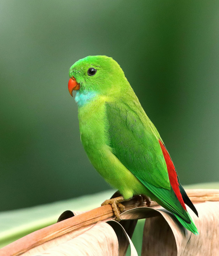

In [6]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "airplan photos":

Searching for 'F16 photos'


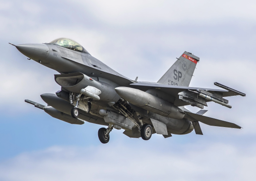

In [7]:
download_url(search_images('F16 photos', max_images=1)[0], 'F16.jpg', show_progress=False)
Image.open('F16.jpg').to_thumb(256,256)

Let's do the same for with "superman photos"

Searching for 'superman photos'


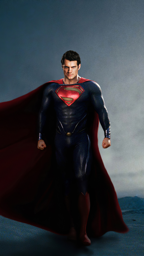

In [8]:
download_url(search_images('superman photos', max_images=1)[0], 'superman.jpg', show_progress=False)
Image.open('superman.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

** My Insert Note:** The folders alphabetical order will be the labels

In [9]:
searches = 'bird', 'f16', 'superman'
path = Path('bird_plane_or_superman')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'
Searching for 'f16 photo'
Searching for 'f16 sun photo'
Searching for 'f16 shade photo'
Searching for 'superman photo'
Searching for 'superman sun photo'
Searching for 'superman shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

15

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

**My Insert Note:** you may see nonsenical images that does not fit our search

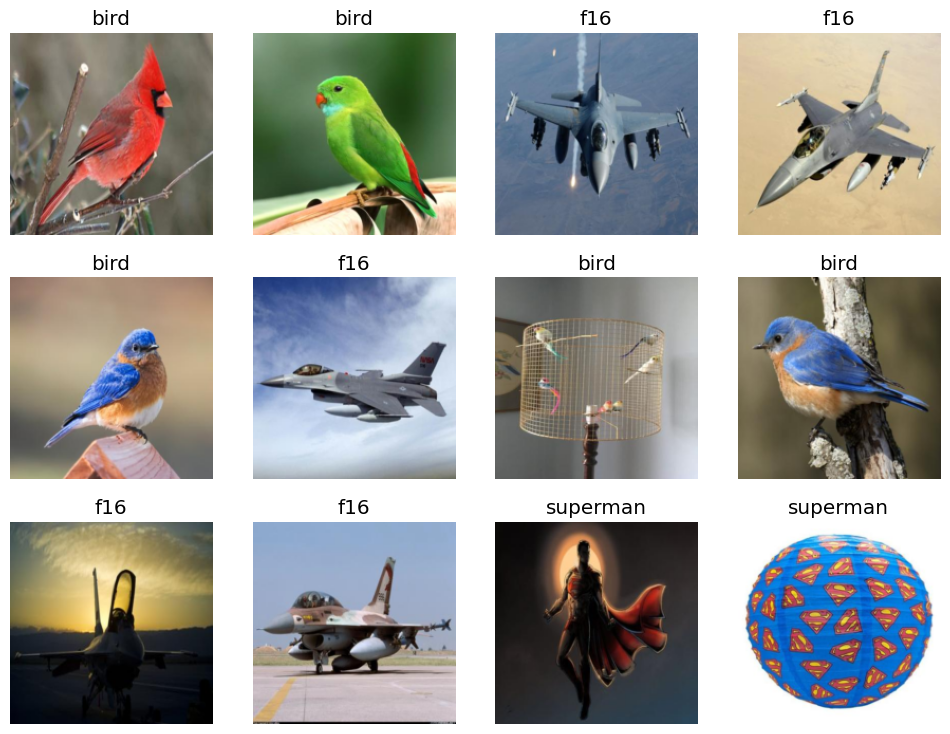

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.641312,0.504868,0.191489,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.358590,0.169117,0.063830,00:01
1,0.212495,0.100343,0.021277,00:01
2,0.156312,0.082663,0.021277,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [13]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg')) # bird
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")
print(f"Probability it's a plane: {probs[1]:.4f}")
print(f"Probability it's a superman: {probs[2]:.4f}")

This is a: bird.
Probability it's a bird: 0.9990
Probability it's a plane: 0.0000
Probability it's a superman: 0.0009


Using fastai widget, run the cell with `uploader` defined. It will output a button you can click, so you can select the image you want to classify:

**My Insert Note:** take from '01_intro.ipynb'

In [18]:
#hide_output
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

Now you can pass the uploaded file to the model. Make sure that it is a clear photo of a single bird, f16 or superman, and not a line drawing, cartoon, or similar. The notebook will tell you whether it thinks it is a bird, plane or superman, and how confident it is. Hopefully, you'll find that your model did a great job:

In [19]:
img = PILImage.create(uploader.data[0])
is_bird,_,probs = learn.predict(img)
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")
print(f"Probability it's a plane: {probs[1]:.4f}")
print(f"Probability it's a superman: {probs[2]:.4f}")

This is a: bird.
Probability it's a bird: 0.9968
Probability it's a plane: 0.0006
Probability it's a superman: 0.0026


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.